# Spatial modeling post modeling figure and table construction

-   post-modeling visualization
-   environmental correlations
-   soil and point map generation
-   gridding example plot

In [57]:
load_packages <- function(packages) {
  # Check for uninstalled packages
  uninstalled <- packages[!packages %in% installed.packages()[,"Package"]]
  
  # Install uninstalled packages
  if(length(uninstalled)) install.packages(uninstalled, dependencies = TRUE)

  # Load all packages
  for (pkg in packages) {
    if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
      message(paste("Failed to load package:", pkg))
    }
  }
}

# List of packages to check, install, and load
packages <- c("tidyverse", "mgcv", "stars", "terra",  
              "ggpubr", "patchwork", "janitor", "sf","tidyterra",
              "here","ggpubr","MetBrewer","rnaturalearth",'viridis','broom')

load_packages(packages)

i_am('README.md')

# Setting R options for jupyterlab
options(repr.plot.width = 10, repr.plot.height = 10)


Installing package into ‘/home/datascience/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

also installing the dependencies ‘operator.tools’, ‘slippymath’, ‘formula.tools’, ‘hexbin’, ‘maptiles’, ‘metR’, ‘vdiffr’



Attaching package: ‘tidyterra’


The following object is masked from ‘package:stats’:

    filter


here() starts at /home/datascience/herbivore_nutrient_interactions


# Section 1 - Post spatial modeling visualization

## Nitrogen and Phosphorus

showing the relationship between outbreak and nil observations to soil nitrogen and phosphorus

In [344]:

outbreak_model_results <- read_csv(here("output/spatial_modeling/outbreak_model_smooth_estimates.csv"),show_col_types = FALSE) |>
    filter(.smooth %in% c('s(nitrogen)','s(phosphorus)')) |>
    select(.smooth,.estimate,.se,nitrogen,phosphorus) |>
    mutate(model = 'outbreak')


nil_model_results <- read_csv(here("output/spatial_modeling/nil_model_smooth_estimates.csv"),show_col_types = FALSE) |>
    filter(.smooth %in% c('s(nitrogen)','s(phosphorus)')) |>
    select(.smooth,.estimate,.se,nitrogen,phosphorus)  |>
    mutate(model = 'nil')

combine_dat <- rbind(outbreak_model_results,nil_model_results)

In [345]:
combine_dat |> head()

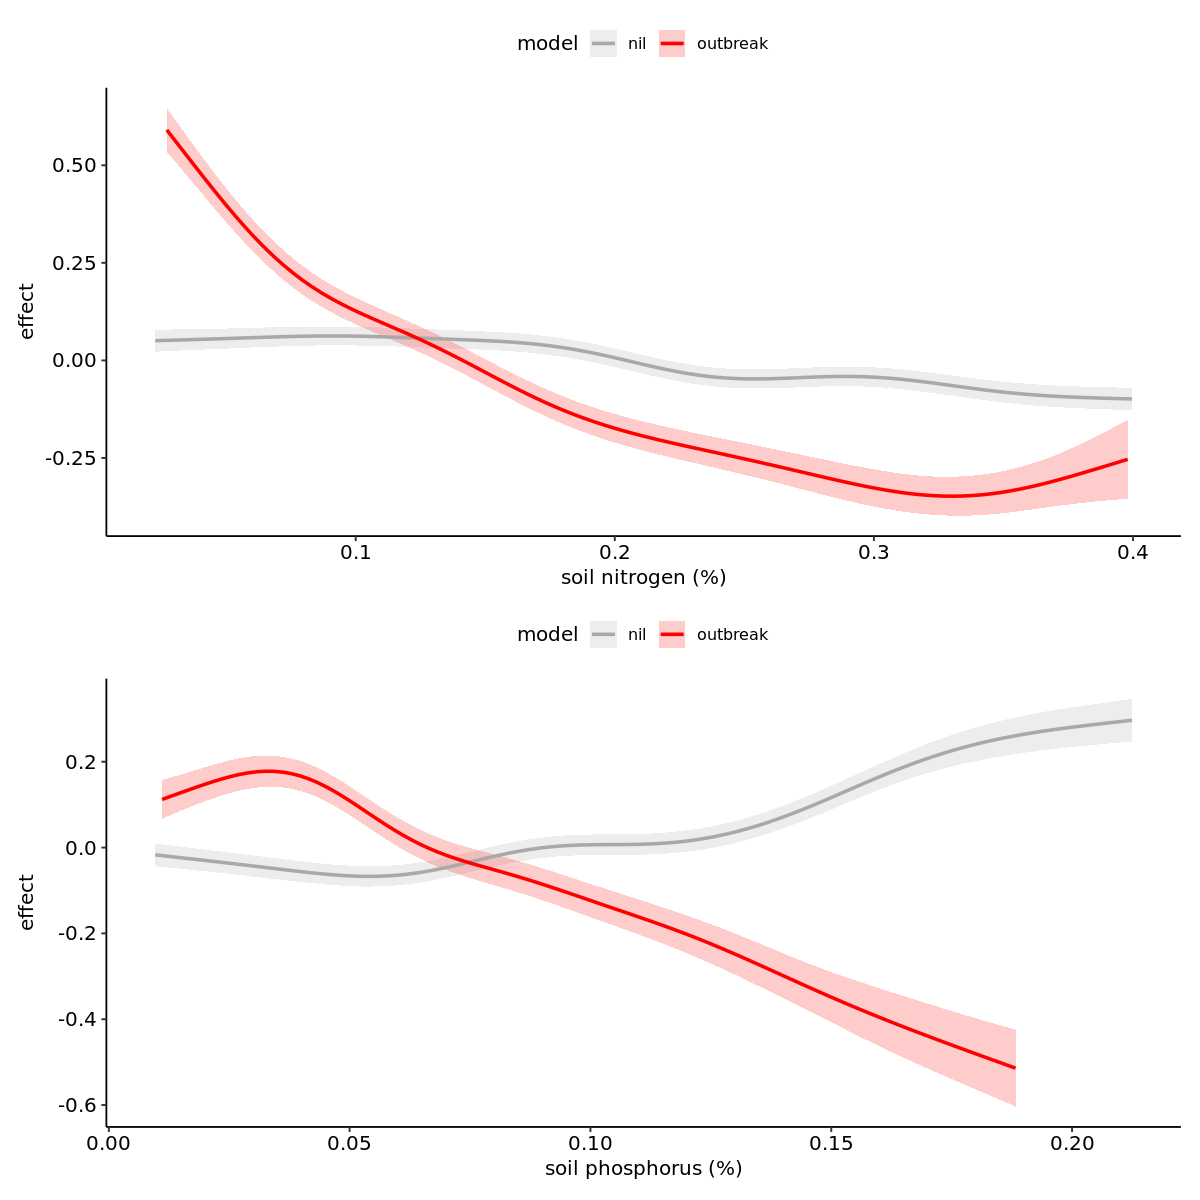

In [346]:
p1 <- combine_dat |>
  filter(.smooth == "s(nitrogen)") |>
  ggplot(aes(x=nitrogen)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se,fill=model),alpha=.2) +
    geom_line(aes(y = .estimate ,color=model),size=1) + 
    theme_pubr() +
    scale_color_manual(values = c('dark grey','red'))  +
    scale_fill_manual(values = c('dark grey','red')) +
    xlab("soil nitrogen (%)") +
    ylab("effect")

p2 <- combine_dat |>
  filter(.smooth == "s(phosphorus)") |>
  ggplot(aes(x=phosphorus)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se,fill=model),alpha=.2) +
    geom_line(aes(y = .estimate ,color=model),size=1) + 
    theme_pubr() +
    scale_color_manual(values = c('dark grey','red'))  +
    scale_fill_manual(values = c('dark grey','red')) +
    xlab("soil phosphorus (%)") +
    ylab("effect")

soil_outbreak_plot <- (p1) / (p2)
soil_outbreak_plot

In [347]:

ggsave(soil_outbreak_plot,
       file=here('output/publication_figures/spatial_modeling_locust_outbreak_with_soil_NTO_PTO.png'),
       width=5,height=10)

## Other variable visualization – outbreaks

In [358]:
outbreak_model_results <- read_csv(here("output/spatial_modeling/outbreak_model_smooth_estimates.csv"),show_col_types = FALSE)

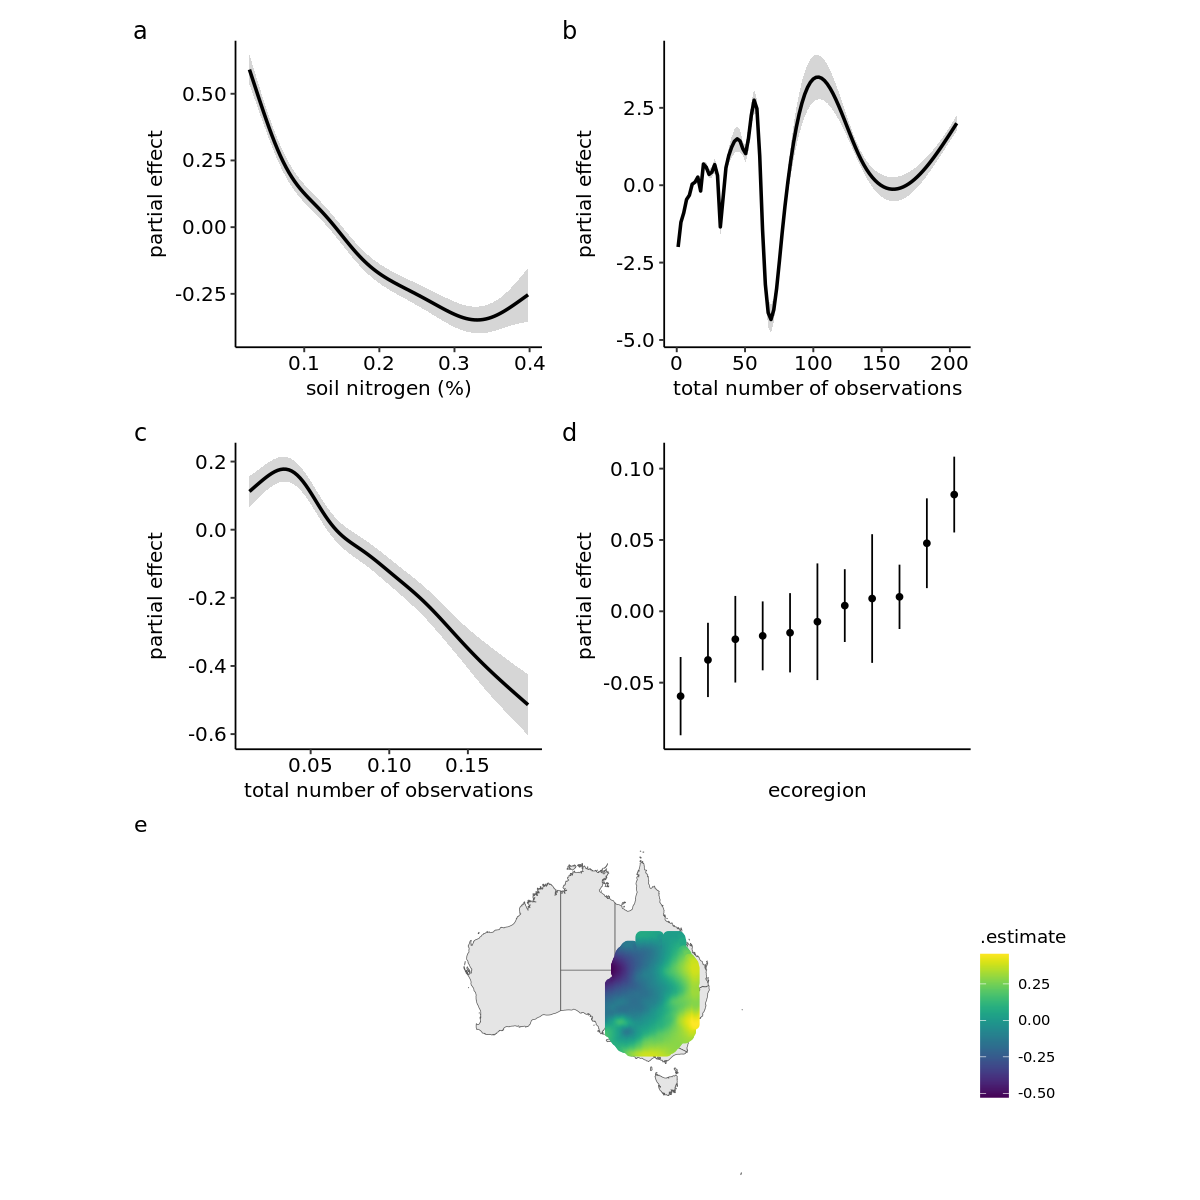

In [362]:


p1 <- outbreak_model_results |>
  filter(.smooth == "s(nitrogen)") |>
  ggplot(aes(x=nitrogen)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se),alpha=.2) +
    geom_line(aes(y = .estimate),size=1) + 
    theme_pubr() +
    xlab("soil nitrogen (%)") +
    ylab("partial effect")

p2 <- outbreak_model_results |>
  filter(.smooth == "s(nymph_density_total_count)") |>
  ggplot(aes(x=nymph_density_total_count)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se),alpha=.2) +
    geom_line(aes(y = .estimate),size=1) + 
    theme_pubr() +
    xlab("total number of observations") +
    ylab("partial effect")

aus <- ne_states(country = 'Australia')

map_dat <- outbreak_model_results |>
    drop_na(longitude,latitude,.estimate) |>
    st_as_sf(coords = c("longitude", "latitude"),crs= "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

p3 <- aus |>
    ggplot() +
        geom_sf() +
        geom_sf(data=map_dat,aes(color=.estimate)) +
        scale_color_viridis() +
        theme_void()

p4 <- outbreak_model_results |>
  filter(.smooth == "s(phosphorus)") |>
  ggplot(aes(x=phosphorus)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se),alpha=.2) +
    geom_line(aes(y = .estimate),size=1) + 
    theme_pubr() +
    xlab("total number of observations") +
    ylab("partial effect")

p5 <- outbreak_model_results |>
    drop_na(ecoregion) |>
    ggplot(aes(y=.estimate, x=reorder(ecoregion,.estimate))) +
        geom_point() +
        geom_errorbar(aes(ymin = .estimate - .se, ymax = .estimate + .se),width=0) +
        theme_pubr() +
        ylab('partial effect') +
        xlab('ecoregion') +
        theme(axis.text.x=element_blank(),
            axis.ticks.x=element_blank())


layout <- '
AB
CD
EE
'

outbreak_all_model_variables <- p1 + p2 + p4 + p5 + p3 +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a')

outbreak_all_model_variables

In [363]:
ggsave(soil_outbreak_plot,
       file=here('output/publication_figures/spatial_modeling_outbreak_all_model_variables.png'),
       width=10,height=15)

## Other variable visualization – nil observations

In [352]:
nil_model_results <- read_csv(here("output/spatial_modeling/nil_model_smooth_estimates.csv"),show_col_types = FALSE)

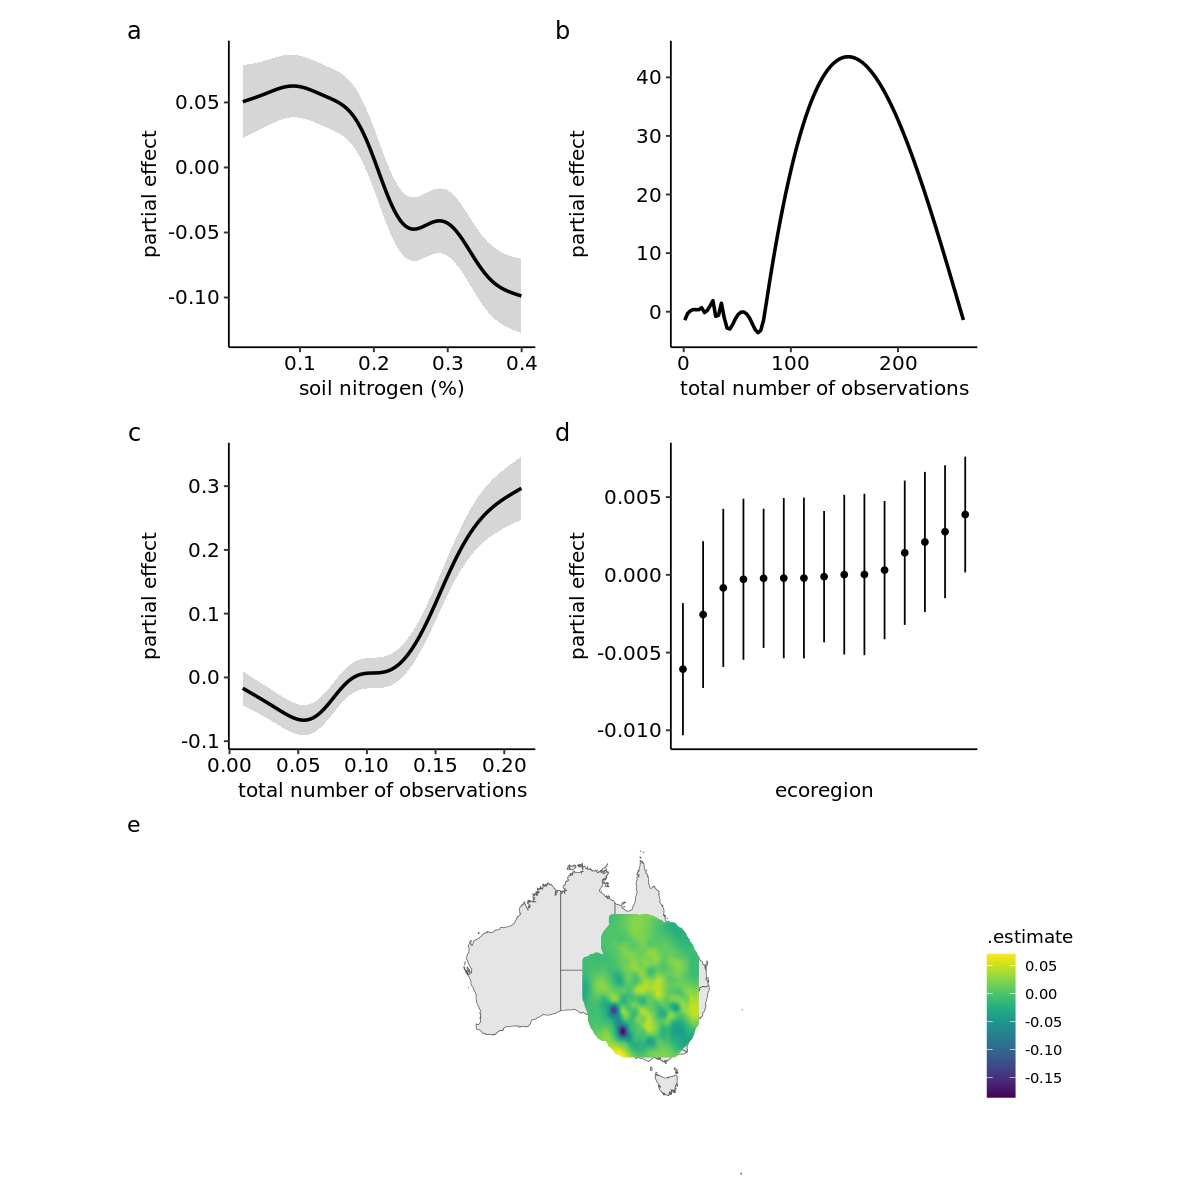

In [356]:


p1 <- nil_model_results |>
  filter(.smooth == "s(nitrogen)") |>
  ggplot(aes(x=nitrogen)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se),alpha=.2) +
    geom_line(aes(y = .estimate),size=1) + 
    theme_pubr() +
    xlab("soil nitrogen (%)") +
    ylab("partial effect")

p2 <- nil_model_results |>
  filter(.smooth == "s(nymph_density_total_count)") |>
  ggplot(aes(x=nymph_density_total_count)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se),alpha=.2) +
    geom_line(aes(y = .estimate),size=1) + 
    theme_pubr() +
    xlab("total number of observations") +
    ylab("partial effect")

aus <- ne_states(country = 'Australia')

map_dat <- nil_model_results |>
    drop_na(longitude,latitude,.estimate) |>
    st_as_sf(coords = c("longitude", "latitude"),crs= "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

p3 <- aus |>
    ggplot() +
        geom_sf() +
        geom_sf(data=map_dat,aes(color=.estimate)) +
        scale_color_viridis() +
        theme_void()

p4 <- nil_model_results |>
  filter(.smooth == "s(phosphorus)") |>
  ggplot(aes(x=phosphorus)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se),alpha=.2) +
    geom_line(aes(y = .estimate),size=1) + 
    theme_pubr() +
    xlab("total number of observations") +
    ylab("partial effect")

p5 <- nil_model_results |>
    drop_na(ecoregion) |>
    ggplot(aes(y=.estimate, x=reorder(ecoregion,.estimate))) +
        geom_point() +
        geom_errorbar(aes(ymin = .estimate - .se, ymax = .estimate + .se),width=0) +
        theme_pubr() +
        ylab('partial effect') +
        xlab('ecoregion') +
        theme(axis.text.x=element_blank(),
            axis.ticks.x=element_blank())


layout <- '
AB
CD
EE
'

nil_all_model_variables <- p1 + p2 + p4 + p5 + p3 +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a')

nil_all_model_variables

In [357]:
ggsave(nil_all_model_variables,
       file=here('output/publication_figures/spatial_modeling_nil_all_model_variables.png'),
       width=10,height=15)

## mean annual precipitation correlations

In [382]:
map_outbreak <- read_csv(here("output/spatial_modeling/map_outbreak_model_smooth_estimates.csv"),show_col_types = FALSE) |>
    drop_na(bio12) |>
    mutate(model = 'outbreak')

map_nil <- read_csv(here("output/spatial_modeling/map_nill_model_smooth_estimates.csv"),show_col_types = FALSE) |>
    drop_na(bio12) |>
    mutate(model = 'nil')


map_mod_results <- rbind(map_outbreak,map_nil)
map_mod_results |> head()

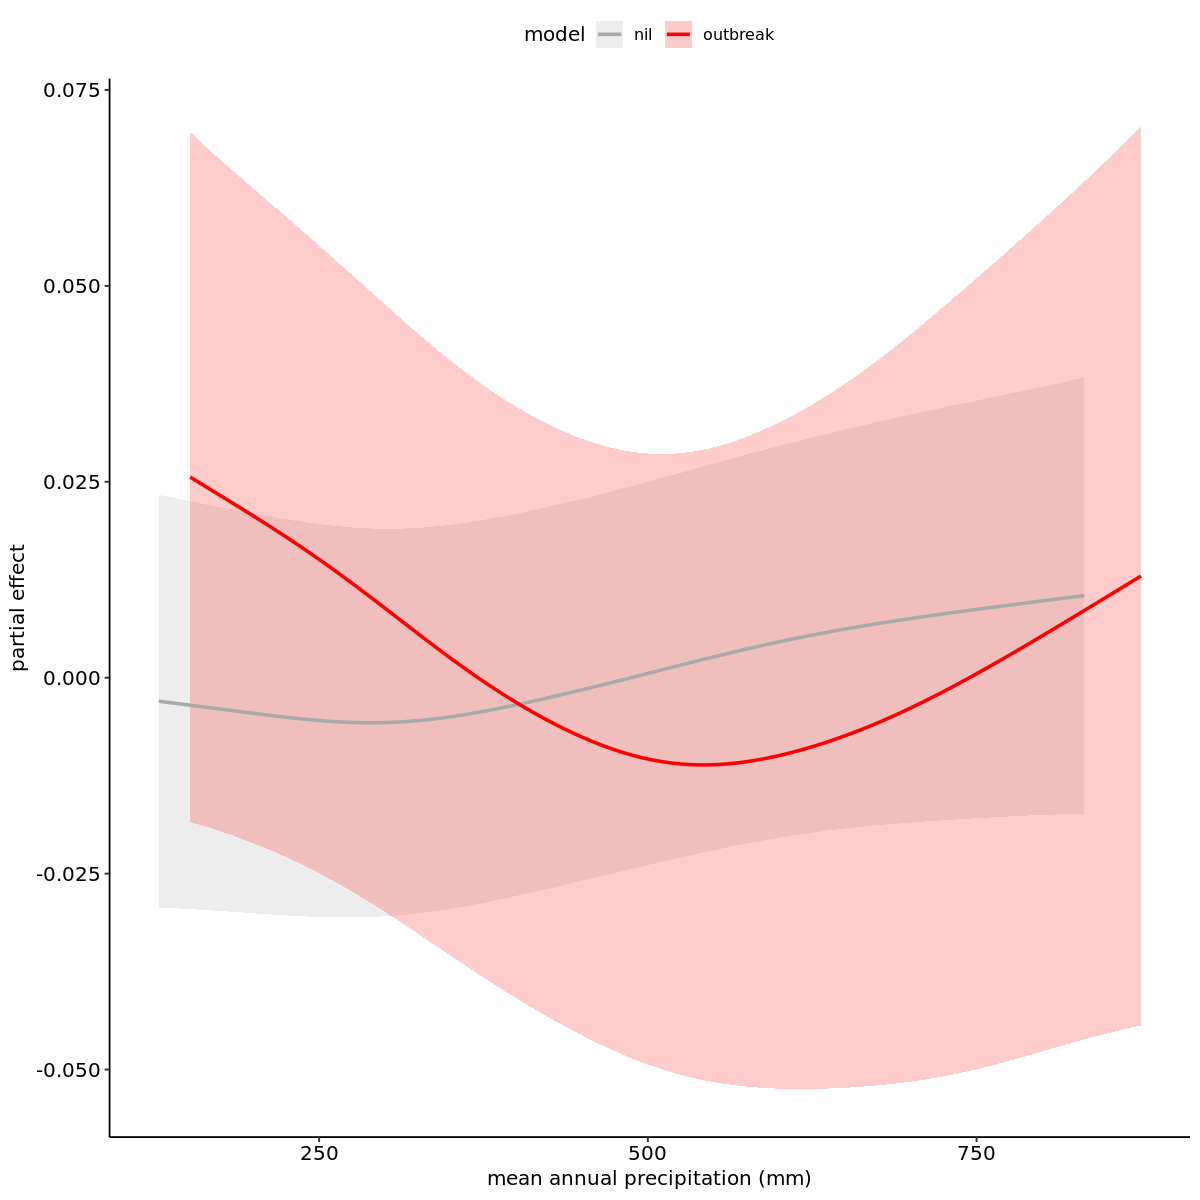

In [383]:
p1 <- map_mod_results |>
  filter(.smooth == "s(bio12)") |>
  ggplot(aes(x=bio12)) + 
    geom_ribbon(aes(ymin=.estimate - .se, ymax=.estimate + .se,fill=model),alpha=.2) +
    geom_line(aes(y = .estimate ,color=model),size=1) + 
    theme_pubr() +
    scale_color_manual(values = c('dark grey','red'))  +
    scale_fill_manual(values = c('dark grey','red')) +
    xlab("mean annual precipitation (mm)") +
    ylab("partial effect")


p1

In [384]:
ggsave(p1,
       file=here('output/publication_figures/spatial_modeling_locust_outbreak_with_map.png'),
       width=5,height=5)

# Section 2 - environmental correlations

This is just a randomly sampled 100k points between the soil and bioclim variables on google earth engine. This extraction code can be found here: `04_environmental_correlations_map_nitrogen_phosphorus_woody_cover.ipynb`

Specifically these correlations:

-   soil nitrogen x soil phosphorus
-   soil nitrogen x woody veg
-   soil nitrogen x MAP
-   soil phosphorus x woody veg
-   MAP x woody veg

In [35]:
# I min-max normalize to get all variables into the same scale for plotting.

minmax <- function(x, na.rm = TRUE) {
    return((x- min(x)) /(max(x)-min(x)))
}

env_dat <- read_csv(here('data/processed/spatial_modeling/environmental_correlation_data.csv'),show_col_types = FALSE) |>
    drop_na() |>
    mutate(mean_nto = minmax((NTO_000_005_EV + NTO_005_015_EV) / 2),
           mean_pto = minmax((PTO_000_005_EV + PTO_005_015_EV) / 2),
           annual_precip = minmax(bio12),
           tree_cover = minmax(tree_canopy_cover)) |>
    select(mean_pto,mean_nto,annual_precip,tree_cover)

env_dat |> head()

In [30]:
nto_pto_graph <- env_dat |>
    #slice_sample(n=10000) |>
    ggplot(aes(x=mean_nto,y=mean_pto)) +
        geom_abline(slope=1,linetype=3,linewidth=1.4) +
        geom_point(pch=21,alpha=0.3) +
        geom_smooth(method='gam',se=FALSE,linewidth=1.4) +
        xlim(0,1) +
        ylim(0,1) +
        theme_pubr() +
        xlab('soil nitrogen') +
        ylab('soil phosphorus')

nto_woody_graph <- env_dat |>
    #slice_sample(n=10000) |>
    ggplot(aes(x=mean_nto,y=tree_cover)) +
        geom_abline(slope=1,linetype=3,linewidth=1.4) +
        geom_point(pch=21,alpha=0.3) +
        geom_smooth(method='gam',se=FALSE,linewidth=1.4) +
        xlim(0,1) +
        ylim(0,1) +
        theme_pubr() +
        xlab('soil nitrogen') +
        ylab('woody tree cover')

nto_map_graph <- env_dat |>
    #slice_sample(n=10000) |>
    ggplot(aes(x=mean_nto,y=annual_precip)) +
        geom_abline(slope=1,linetype=3,linewidth=1.4) +
        geom_point(pch=21,alpha=0.3) +
        geom_smooth(method='gam',se=FALSE,linewidth=1.4) +
        xlim(0,1) +
        ylim(0,1) +
        theme_pubr() +
        xlab('soil nitrogen') +
        ylab('annual precipitation')

pto_woody_graph <- env_dat |>
    #lice_sample(n=10000) |>
    ggplot(aes(x=mean_pto,y=tree_cover)) +
        geom_abline(slope=1,linetype=3,linewidth=1.4) +
        geom_point(pch=21,alpha=0.3) +
        geom_smooth(method='gam',se=FALSE,linewidth=1.4) +
        xlim(0,1) +
        ylim(0,1) +
        theme_pubr() +
        xlab('soil phosphorus') +
        ylab('woody tree cover')

pto_map_graph <- env_dat |>
    #slice_sample(n=10000) |>
    ggplot(aes(x=mean_pto,y=annual_precip)) +
        geom_abline(slope=1,linetype=3,linewidth=1.4) +
        geom_point(pch=21,alpha=0.3) +
        geom_smooth(method='gam',se=FALSE,linewidth=1.4) +
        xlim(0,1) +
        ylim(0,1) +
        theme_pubr() +
        xlab('soil phosphorus') +
        ylab('annual precipitation')
        

In [137]:
layout <- "
AB
CD
E#
"
env_correlation_graph <- nto_pto_graph + nto_woody_graph + nto_map_graph + pto_woody_graph + pto_map_graph +
  plot_layout(design = layout) + plot_annotation(tag_levels = 'a') 

In [138]:
ggsave(env_correlation_graph,file=here('output/publication_figures/spatial_modeling_environment_correlation_figure.png'),width=10,height=15)

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'

# Section 3 - soil and point map generation

This figure will combine a few figures: - raw point distribution through australia - soil nitrogen map clipped to the locust distribution - soil phosphorus map clipped to the locust distribution

In [47]:
aus <- ne_states(country='Australia') |> 
    select(name,geometry)

point_dat <- read_csv(here('data/raw/survey_data/CT.csv'),show_col_types = FALSE) |>
    select(!`...1`) |>
    select(Latitude,Longitude,Species) |>
    st_as_sf(coords = c("Longitude", "Latitude"),
             crs= "+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")

nto_rast <- rast(here("data/raw/survey_data/apl_nitrogen_raster.tif"))
pto_rast <- rast(here("data/raw/survey_data/apl_phosphorus_raster.tif"))

New names:
• `` -> `...1`

In [58]:
nto_rast

class       : SpatRaster 
dimensions  : 1139, 2062, 1  (nrow, ncol, nlyr)
resolution  : 0.01796631, 0.01796631  (x, y)
extent      : 114.6789, 151.7255, -37.76517, -17.30155  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : apl_nitrogen_raster.tif 
name        : apl_nitrogen_raster 

In [191]:


point_map <- ggplot(aus) +
    geom_sf() +
    geom_sf(data=point_dat,size = 0.25) +
    theme_void() # + theme(legend.position="none")

nto_map <- ggplot(aus) +
    geom_sf(color=NA) +
    geom_spatraster(data = nto_rast, aes(fill = apl_nitrogen_raster))  +
    scale_fill_stepsn(n.breaks = 10,
                      colours = rev(terrain.colors(5)),
                      na.value = "transparent",
                      trans='log',
                      name="soil nitrogen \n(log-scaled)") +
    geom_sf(data = aus,fill=NA) +
    theme_void()  #+ theme(legend.position="none")

pto_map <-ggplot(aus) +
    geom_sf(color=NA) +
    geom_spatraster(data = pto_rast, aes(fill = apl_phosphorus_raster))  +
    scale_fill_stepsn(breaks= c(0.14,0.10,0.05,0.04,0.02,0.01),
                      colours = viridis::viridis(9),
                      na.value = "transparent",
                      trans='log',
                      name="soil phosphorus \n(log-scaled)") +
    geom_sf(data = aus,fill=NA) +
    theme_void()  #+ theme(legend.position="none")


<SpatRaster> resampled to 500752 cells.
<SpatRaster> resampled to 500752 cells.

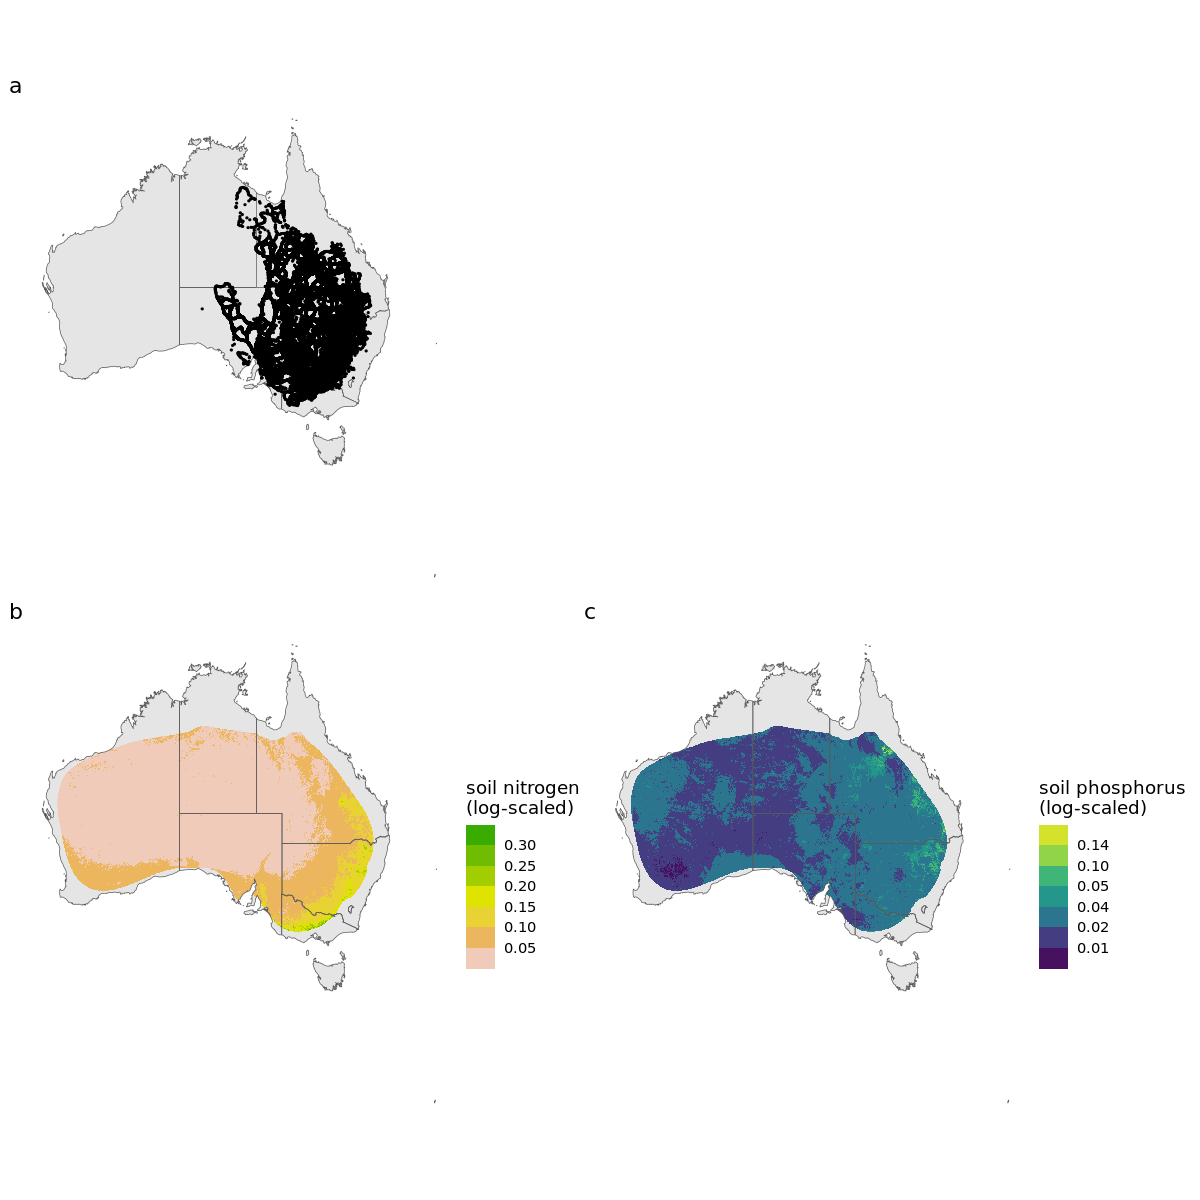

In [271]:

layout2 <- "
AAAA
AAAA
AAAA
AAAA
BBCC
BBCC
BBCC
BBCC
"
layout <- "
A#
BC
"

locust_env_maps <- point_map + nto_map + pto_map + 
    plot_annotation(tag_levels = 'a') +
    plot_layout(design = layout)

locust_env_maps

In [272]:
asp_ratio <- tmaptools::get_asp_ratio(aus)

ggsave(locust_env_maps,
       file=here('output/publication_figures/spatial_modeling_locust_env_map.png'),
       width=10*asp_ratio,height=10)

# Section 4 - griding example

I want to show an example gridding of the apl points

In [197]:
apl_distribution = st_read(here("data/raw/survey_data/australian_plague_locut_distribution/Australia_Locust_Distribution.shp"))
apl_distribution

Reading layer `Australia_Locust_Distribution' from data source 
  `/home/datascience/herbivore_nutrient_interactions/data/raw/survey_data/australian_plague_locut_distribution/Australia_Locust_Distribution.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 114.6879 ymin: -37.75311 xmax: 151.7099 ymax: -17.30655
Geodetic CRS:  GDA94

In [265]:

# Creating a grid with cells 4000m x 4000m 
grid = st_make_grid(point_dat, cellsize = 1, 
                            what ="polygons", square = T)

overall_grid_map <- ggplot(aus) +
    geom_sf() +
    geom_sf(data=point_dat) +
    geom_sf(data=grid,fill=NA,color='red') +
    theme_void()  +
  theme(
    plot.background = element_rect(fill = "white", color = NA)  # Set white background
  )

In [246]:
grid

POLYGON ((131.6556 -37.71413, 132.6556 -37.7141...

POLYGON ((132.6556 -37.71413, 133.6556 -37.7141...

POLYGON ((133.6556 -37.71413, 134.6556 -37.7141...

POLYGON ((134.6556 -37.71413, 135.6556 -37.7141...

POLYGON ((135.6556 -37.71413, 136.6556 -37.7141...


Geometry set for 440 features 
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 131.6556 ymin: -37.71413 xmax: 151.6556 ymax: -15.71413
Geodetic CRS:  +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0
First 5 geometries:

In [228]:
nsw <- aus |> filter(name == 'New South Wales')

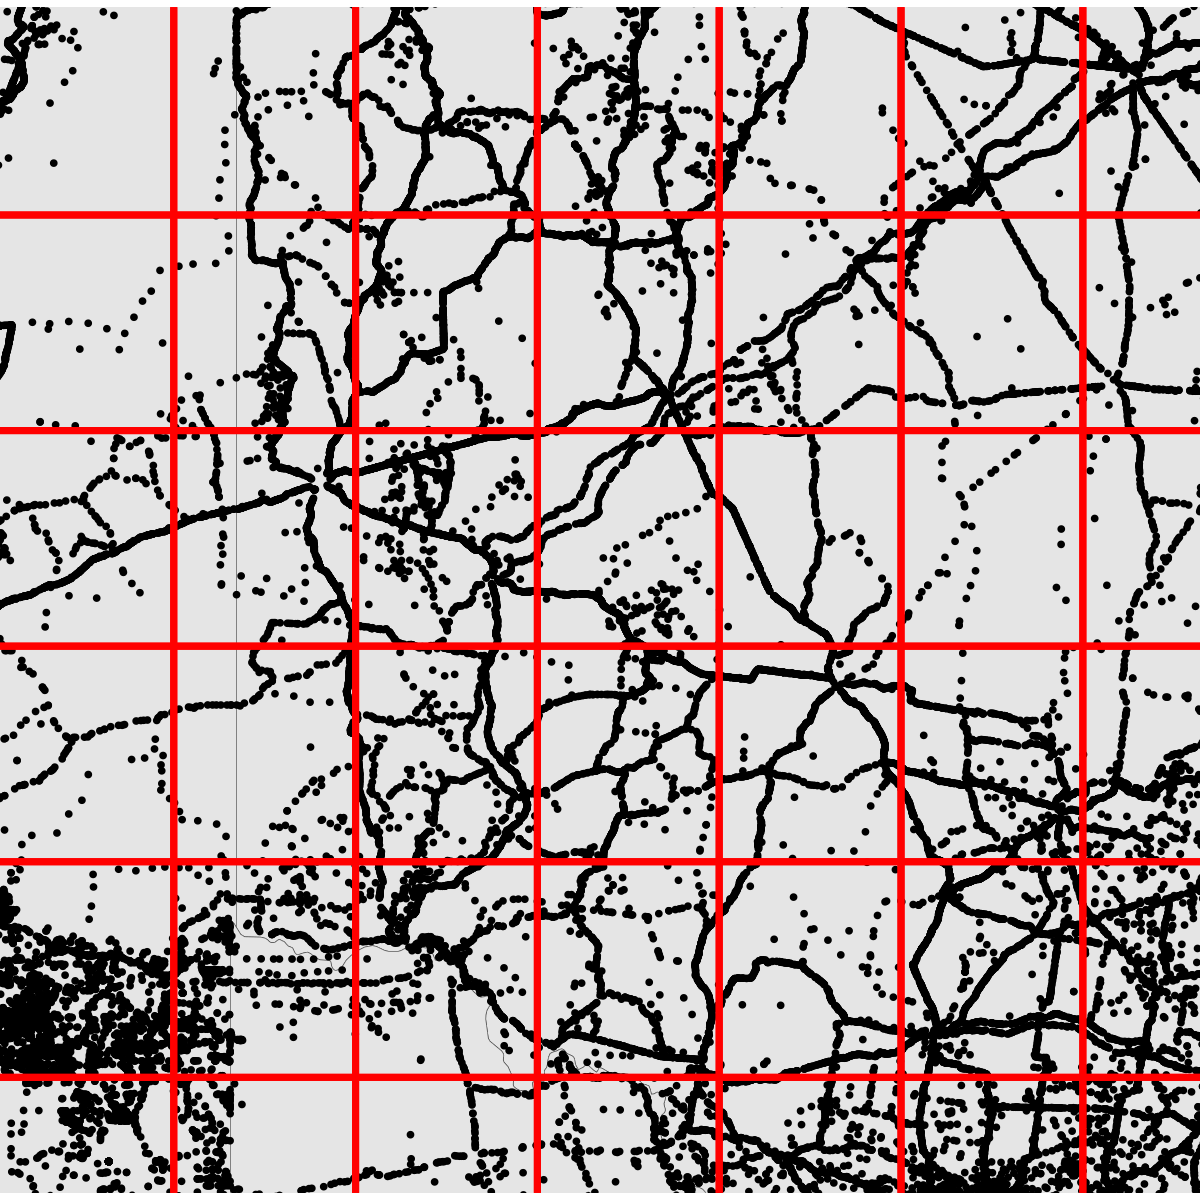

In [263]:
zoomed_plot <- ggplot(aus) +
    geom_sf() +
    geom_sf(data=point_dat) +
    geom_sf(data=grid,fill=NA,color='red',linewidth=2) +
    coord_sf(ylim = c(-30, -35), xlim = c(140, 146)) +
    theme_void()

zoomed_plot

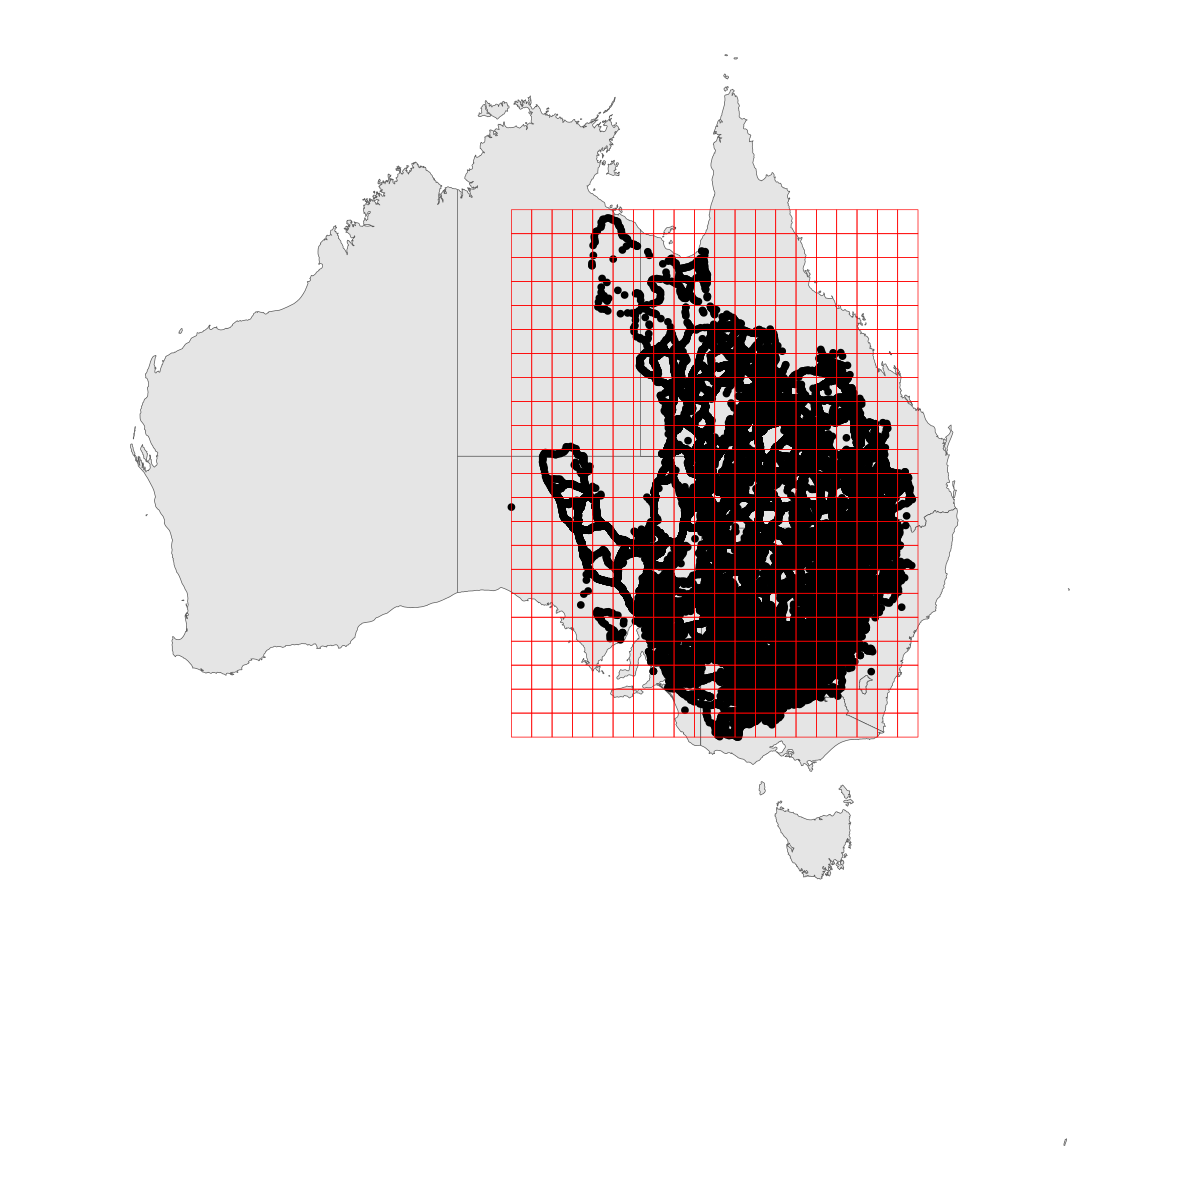

In [258]:
overall_grid_map

In [268]:
grid_examples <- zoomed_plot + overall_grid_map

In [274]:
asp_ratio <- tmaptools::get_asp_ratio(aus)

ggsave(grid_examples,
       file=here('output/publication_figures/spatial_modeling_grid_example_map.png'),
       width=10*asp_ratio,height=5)

# Section 5 - table construction

In [380]:
outbreak_mod <- readRDS(here("output/spatial_modeling/model_objects/locust_outbreak_model.rds")) |>
    tidy() |>
    mutate(model = 'outbreak')

nil_mod <- readRDS(here("output/spatial_modeling/model_objects/locust_nil_model.rds")) |>
    tidy()  |>
    mutate(model = 'nil')

map_outbreak_mod <- readRDS(here("output/spatial_modeling/model_objects/locust_outbreak_map_model.rds"))|>
    tidy()  |>
    mutate(model = 'outbreak')

map_nil_outbreak_mod <- readRDS(here("output/spatial_modeling/model_objects/locust_nil_map_model.rds"))|>
    tidy()  |>
    mutate(model = 'nil')


overall_mods <-outbreak_mod |> rbind(nil_mod)

map_mods <-map_outbreak_mod |> rbind(map_nil_outbreak_mod)

In [381]:
write.csv(overall_mods, here("output/spatial_modeling/map_outbreak_model_results.csv"),row.names=FALSE)
